In [1]:
!pip install -U fiona shapely pyproj rtree

!pip install -U geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.13.2
    Uninstalling geopandas-0.13.2:
      Successfully uninstalled geopandas-0.13.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

from os import mkdir

from tqdm import tqdm

from glob import glob

plt.rcParams['font.family'] = 'serif'

In [4]:
def crear_carpeta(ruta):
    try:
        mkdir(ruta)
        print(f"Carpeta '{ruta}' creada exitosamente.")
    except FileExistsError:
        print(f"La carpeta '{ruta}' ya existe.")
    except Exception as e:
        print(f"Error al crear la carpeta '{ruta}': {e}")

In [5]:
colonias = gpd.read_file('zip:///content/drive/MyDrive/Colonias CDMX/data/espacial/colonias_seduvi.zip').drop(columns=['pob_2010','area','perimetro','cve_ent'])

In [6]:
filesinvial = glob('/content/drive/MyDrive/Colonias CDMX/data/variables/inViales_*.csv')

In [7]:
ls_df = [pd.read_csv(file,
                     usecols=['incidente_c4','longitud','latitud','fecha_creacion'],
                     encoding='latin1') for file in filesinvial]

In [8]:
c5_full = pd.concat(ls_df, ignore_index=True)
c5_full.sort_values('fecha_creacion', inplace=True)
c5_full['cnt']=1
try:
    c5_full['fecha_creacion'] = c5_full['fecha_creacion'].astype(str).str[-4:].astype(int)
except ValueError:
    c5_full['fecha_creacion'] = c5_full['fecha_creacion'].astype(str).str[:4].astype(int)

In [9]:
new_columns = {
    'Accidente automovilÃ­stico': 'AccAuto',
    'Atropellado': 'Atrop',
    'Choque con lesionados': 'ChoqLes',
    'Choque con prensados': 'ChoqPres',
    'Choque sin lesionados': 'ChoqSLes',
    'Ciclista': 'Ciclista',
    'Ferroviario': 'Ferrovia',
    'Incidente de trÃ¡nsito': 'IncTran',
    'MonopatÃ­n': 'Monopatin',
    'Motociclista': 'Motocicl',
    'Otros': 'Otros',
    'Persona atrapada / desbarrancada': 'PersAtrap',
    'Persona atropellada': 'PersAtrop',
    'Vehiculo desbarrancado': 'VehDesb',
    'VehÃ­culo atrapadovarado': 'VehAtrap',
    'Vehiculo atrapado': 'VehAtrapad',
    'Volcadura': 'Volcadura'
}

In [10]:
def process_c5_data(c5_full, colonias, year):
    c5 = c5_full.query(f'fecha_creacion == {year}').copy()
    geo_c5 = gpd.GeoDataFrame(c5,
                            geometry=gpd.points_from_xy(c5.longitud, c5.latitud),
                            crs='epsg:4326').to_crs(colonias.crs)
    colonias_c5 = gpd.sjoin_nearest(colonias, geo_c5,
                                        distance_col='dist', how="right")

    colonias_join = colonias_c5[~colonias_c5.dist.isna()].query('dist<1000').sort_values('dist')
    colonias_join = colonias_join.groupby(['cve_col','colonia','incidente_c4']).cnt.sum().unstack().reset_index().fillna(0)

    colonias_final = pd.merge(colonias, colonias_join, on=['cve_col','colonia'])

    colonias_final['Total'] = colonias_final.iloc[:,4:].sum(axis=1)
    colonias_final['area'] = colonias_final.area
    colonias_final['total_ix'] = 100*(colonias_final['Total']/colonias_final.area)

    colonias_final.rename(columns=new_columns, inplace=True)

    colonias_final = pd.concat([colonias_final,
                                colonias[~(colonias.cve_col.isin(colonias_final.cve_col))]],
                                ignore_index=True
                                ).fillna(0)
    return colonias_final

In [15]:
for year in tqdm(c5_full.fecha_creacion.unique()):
    year = int(year)
    colonias_final = process_c5_data(c5_full, colonias, year)

    crear_carpeta(f'/content/drive/MyDrive/Colonias CDMX/c5/{year}')

    colonias_final.to_file(f'/content/drive/MyDrive/Colonias CDMX/c5/{year}/{year}.shp',
                           index=False)

  0%|          | 0/11 [00:00<?, ?it/s]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2013' ya existe.


  9%|▉         | 1/11 [00:03<00:32,  3.23s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2014' ya existe.


 18%|█▊        | 2/11 [00:19<01:35, 10.65s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2015' ya existe.


 27%|██▋       | 3/11 [00:35<01:47, 13.48s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2016' ya existe.


 36%|███▋      | 4/11 [00:52<01:44, 14.89s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2017' ya existe.


 45%|████▌     | 5/11 [01:16<01:47, 17.98s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2018' ya existe.


 55%|█████▍    | 6/11 [01:38<01:37, 19.47s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2019' ya existe.


 64%|██████▎   | 7/11 [02:00<01:20, 20.15s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2020' ya existe.


 73%|███████▎  | 8/11 [02:15<00:55, 18.60s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2021' ya existe.


 82%|████████▏ | 9/11 [02:33<00:36, 18.39s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2022' ya existe.


 91%|█████████ | 10/11 [02:54<00:19, 19.12s/it]

La carpeta '/content/drive/MyDrive/Colonias CDMX/c5/2023' ya existe.


100%|██████████| 11/11 [03:02<00:00, 16.63s/it]


In [13]:
colonias_final = process_c5_data(c5_full, colonias, 2023).crs

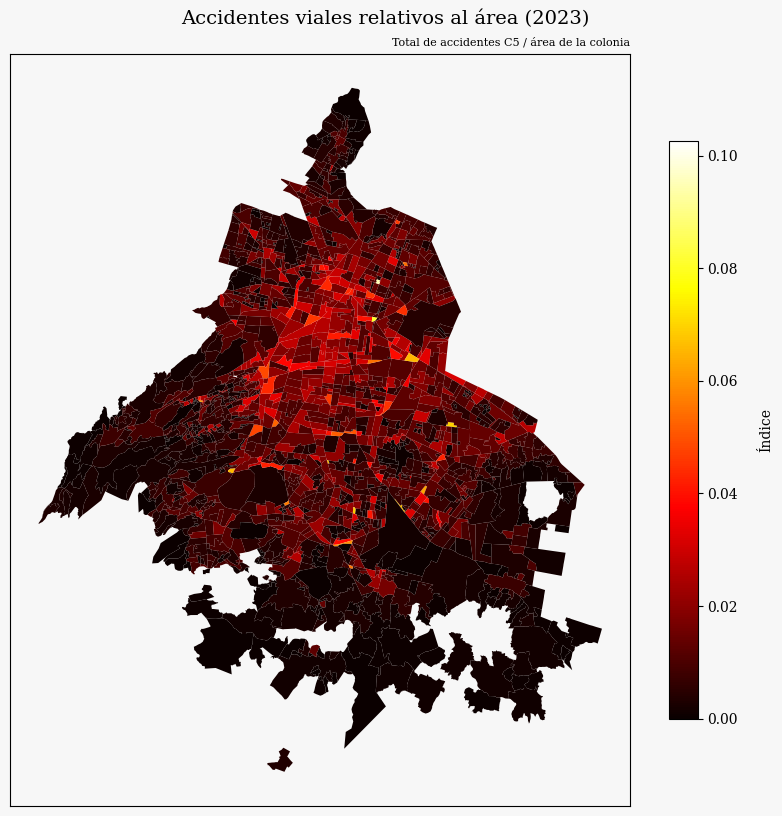

In [16]:
fig = plt.figure(figsize=(10, 15))

ax = colonias_final.plot(column="total_ix", ax=plt.gca(),
                             cmap='hot', legend=True,
                             legend_kwds={"shrink": 0.5},# vmax=20000
                         )


#metro.plot(ax=ax, color='azure', markersize=15, ec='maroon')


color_fondo = '#f7f7f7'
ax.set_facecolor(color_fondo)
fig.patch.set_facecolor(color_fondo)


ax.set_xticks([])
ax.set_yticks([])

plt.suptitle("Accidentes viales relativos al área (2023)", y=0.775, fontsize=14)
plt.title('Total de accidentes C5 / área de la colonia', loc='right', fontsize=8)

cax = ax.get_figure().get_axes()[1]
cax.set_ylabel('Índice', rotation=90, labelpad=15)

# Guardar el gráfico como una imagen (esta línea está comentada)
plt.savefig('/content/drive/MyDrive/Colonias CDMX/c5/mapa_delitos_c5_2023.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()